In [1]:
import networkx as nx
import pandas as pd
import os
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import time
import random
from sklearn.metrics import f1_score
from collections import defaultdict 
from dgl.nn import SAGEConv
import scipy.sparse as sp
import json
import seaborn as sns
import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
import dgl
from dgl.data.utils import save_graphs
from dgl import load_graphs

In [3]:
from dgl.nn import SAGEConv
import dgl.data

In [4]:
from collections import defaultdict

# Graph EDA

In [42]:
os.path.join(os.path.expanduser('~'), './test_save.bin')
glist, label_dict = load_graphs(os.path.join(os.path.expanduser('~'), './test_save.bin'))
g = glist[0]
degs = (g.in_degrees())
np.mean(np.array(degs))

312.876164831353

In [43]:
measures = pd.DataFrame(data=[170089, 26608397, 313, 13], index=['Nodes', 'Edges', 'Average Degree', 'Features'], columns=['Measure'])
measures

,Measure
Nodes,170089
Edges,26608397
Average Degree,313
Features,13


In [ ]:
measures.to_csv('graph_measures.csv')

# Features EDA

In [5]:
numerical = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',]
categorical = ['key', 'mode', 'time_signature']

In [6]:
data_path = (os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/'))

In [11]:
def wowa(thelist):
    eligible = []
    for x in thelist:
        if x == 'playlists':continue
        nums = pd.Series(x.strip('mpd.slice.json').split('-')).astype(int)
        if nums[0] <= 9999:
            eligible.append(x)
    return eligible

In [12]:
wowa(pd.Series(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/'))))

['mpd.slice.4000-4999.json',
 'mpd.slice.9000-9999.json',
 'mpd.slice.0-999.json',
 'mpd.slice.1000-1999.json',
 'mpd.slice.8000-8999.json',
 'mpd.slice.5000-5999.json',
 'mpd.slice.3000-3999.json',
 'mpd.slice.7000-7999.json',
 'mpd.slice.6000-6999.json',
 'mpd.slice.2000-2999.json']

In [13]:
what = np.random.choice(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/')), replace=True)
what

'mpd.slice.393000-393999.json'

In [14]:
file_samp = np.random.choice(wowa(pd.Series(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/')))), replace=True)
fname = os.path.join(data_path, file_samp)
with open(fname) as f:
    data = json.load(f)
    item = np.random.choice(data['playlists'])
item

{'name': 'superman.',
 'collaborative': 'false',
 'pid': 1148,
 'modified_at': 1498435200,
 'num_tracks': 54,
 'num_albums': 39,
 'num_followers': 2,
 'tracks': [{'pos': 0,
   'artist_name': 'Rihanna',
   'track_uri': 'spotify:track:1XrrzhGLErbkiwH5v3xww9',
   'artist_uri': 'spotify:artist:5pKCCKE2ajJHZ9KAiaK11H',
   'track_name': 'Higher',
   'album_uri': 'spotify:album:3Q149ZH46Z0f3oDR7vlDYV',
   'duration_ms': 120626,
   'album_name': 'ANTI'},
  {'pos': 1,
   'artist_name': 'Kanye West',
   'track_uri': 'spotify:track:1eQBEelI2NCy7AUTerX0KS',
   'artist_uri': 'spotify:artist:5K4W6rqBFWDnAN6FQUkS6x',
   'track_name': 'Ultralight Beam',
   'album_uri': 'spotify:album:7gsWAHLeT0w7es6FofOXk1',
   'duration_ms': 320680,
   'album_name': 'The Life Of Pablo'},
  {'pos': 2,
   'artist_name': 'Kanye West',
   'track_uri': 'spotify:track:3nAq2hCr1oWsIU54tS98pL',
   'artist_uri': 'spotify:artist:5K4W6rqBFWDnAN6FQUkS6x',
   'track_name': 'Waves',
   'album_uri': 'spotify:album:7gsWAHLeT0w7es6Fo

In [15]:
%%time
# Saving sample of playlists
playlists = []
for i in range(200):
    file_samp = np.random.choice(wowa(pd.Series(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/')))), replace=True)
    fname = os.path.join(data_path, file_samp)
    with open(fname) as f:
        data = json.load(f)
        item = np.random.choice(data['playlists'])
        playlists.append(item)

CPU times: user 1min 10s, sys: 8.24 s, total: 1min 19s
Wall time: 1min 19s


In [16]:
# with open("" + 'mpd.slice.{}-{}.json'.format(0, 999)) as f:
#         data = json.load(f)
#         playlists = data['playlists']

In [17]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder()

In [18]:
edafeats = pd.read_csv('~/teams/DSC180A_FA21_A00/a13group1/songset_features_170k')
edafeats = edafeats.drop(columns=['Unnamed: 0', 'type', 'track_href', 'analysis_url'])

edafeats['loudness'] = std_scaler.fit_transform(edafeats[['loudness']])
edafeats['tempo'] = std_scaler.fit_transform(edafeats[['tempo']])
edafeats['duration_ms'] = std_scaler.fit_transform(edafeats[['duration_ms']])

In [19]:
playlists[0]['tracks'][7]

{'pos': 7,
 'artist_name': 'Keys N Krates',
 'track_uri': 'spotify:track:3P5CkJ2Hivngpn3e0Qp69S',
 'artist_uri': 'spotify:artist:6c1pBXHYjFcGQQNO5MMsdd',
 'track_name': 'Are We Faded - Original Mix',
 'album_uri': 'spotify:album:3BTRPjLFhotV4O3YleJfoj',
 'duration_ms': 173791,
 'album_name': 'Are We Faded'}

In [20]:
%%time
feat_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_avgs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_difs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_ranges = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

for item in playlists:
    #item = playlists[each]
    
    row_ids = []
    for i in item['tracks']:
        row = edafeats[edafeats['uri'] == i['track_uri']].index.item()
        row_ids.append(row)
        
    
    cur_feats = edafeats.iloc[row_ids]
    
    for i in numerical:
        var = np.var(cur_feats[i])
        feat_vars[i].append(var)
        
        avg = np.mean(cur_feats[i])
        feat_avgs[i].append(avg)
        
        difs = np.mean(np.abs(cur_feats[i].diff())[1:])
        feat_difs[i].append(difs)
        
        ranges = np.abs(np.max(cur_feats[i]) - np.min(cur_feats[i]))
        feat_ranges[i].append(ranges)
        
        
        
    for i in categorical:
        highest = max(cur_feats[i].value_counts() / cur_feats[i].count())
        feat_vars[i].append(highest)

CPU times: user 2min 13s, sys: 183 ms, total: 2min 13s
Wall time: 2min 13s


In [21]:
feat_avgs.pop('key')
feat_avgs.pop('mode')
feat_avgs.pop('time_signature')

feat_difs.pop('key')
feat_difs.pop('mode')
feat_difs.pop('time_signature')

feat_ranges.pop('key')
feat_ranges.pop('mode')
feat_ranges.pop('time_signature')

[]

In [22]:
for i in list(feat_vars.keys()):
    print(i, np.mean(feat_vars[i]))

danceability 0.01663632478344715
energy 0.026919985250298355
loudness 0.3521617742113418
speechiness 0.005986984419693051
acousticness 0.048676114342779624
instrumentalness 0.023712244157477445
liveness 0.018782498200378805
valence 0.043351456301884694
tempo 0.8552642204290177
duration_ms 0.342018467643749
key 0.19672922455769942
mode 0.6790329027463733
time_signature 0.9273018638477478


# Within Playlists EDA (From 200 Song Sample)

When plotting the distribution of variance for danceability of the 200 sampled playlists we can see that it follows a sort of bimodal distribution, where the variance is always quite low. This suggests that the songs within each playlist follow a sort of similarity in danceability. As we plot the variances of the other playlists we can get different values.

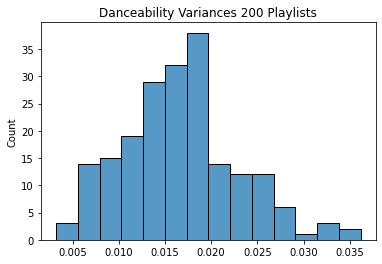

In [26]:
danceability_variances = sns.histplot(feat_vars['danceability']).set(title='Danceability Variances 200 Playlists')

### All Songs

In [27]:
summary = edafeats.describe()
summary.loc['std'] = summary.loc['std'] **2
summary

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,170089.000000,170089.000000,170089.000000,1.700890e+05,170089.000000,170089.000000,170089.000000,170089.000000,170089.000000,170089.000000,1.700890e+05,1.700890e+05,170089.000000
mean,0.569778,0.622020,5.260581,1.398356e-15,0.661783,0.087511,0.287328,0.124194,0.200912,0.472896,1.904146e-17,-4.932490e-17,3.911887
std,0.029490,0.058464,12.800083,1.000006e+00,0.223828,0.009892,0.101317,0.075581,0.030724,0.064343,1.000006e+00,1.000006e+00,0.160849
min,0.000000,0.000000,0.000000,-1.121834e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.121520e+00,-2.338930e+00,0.000000
25%,0.458000,0.459000,2.000000,-3.759491e-01,0.000000,0.034800,0.019000,0.000000,0.096000,0.265000,-7.870530e-01,-4.550188e-01,4.000000
50%,0.581000,0.660000,5.000000,2.501652e-01,1.000000,0.047300,0.141000,0.000037,0.127000,0.460000,-3.429976e-02,-1.318544e-01,4.000000
75%,0.695000,0.820000,8.000000,6.570311e-01,1.000000,0.088900,0.513000,0.020300,0.255000,0.674000,6.398950e-01,2.791778e-01,4.000000
max,0.991000,1.000000,11.000000,2.379820e+00,1.000000,0.963000,0.996000,0.999000,1.000000,1.000000,3.900397e+00,5.003347e+01,5.000000


In [ ]:
summary.to_csv('edafeats_summary')

### 200 Samples of Length 70 Each

In [ ]:
# Get Average playlist length
playlist_lens = []
for i in playlists:
    playlist_lens.append(len(i['tracks']))
mean_playlist_len = np.mean(playlist_lens)
mean_playlist_len

In [ ]:
len(playlists)


In [ ]:
len(edafeats)


In [ ]:
song_samps = []
song_samp_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

for item in range(200):
    # Sample 70 songs
    songs = edafeats.iloc[np.random.choice(170089, 70)]
    
    for i in numerical:
        var = np.var(songs[i])
        song_samp_vars[i].append(var)
        
    for i in categorical:
        highest = max(songs[i].value_counts() / songs[i].count())
        song_samp_vars[i].append(highest)

In [ ]:
song_sample_vars_plot = pd.DataFrame(song_samp_vars)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))
plt.savefig('song_sample_vars_plot.jpg')

I will take a sample of 200 random songs and look at the measures of that too to compare.

# Playlist Feature Plots

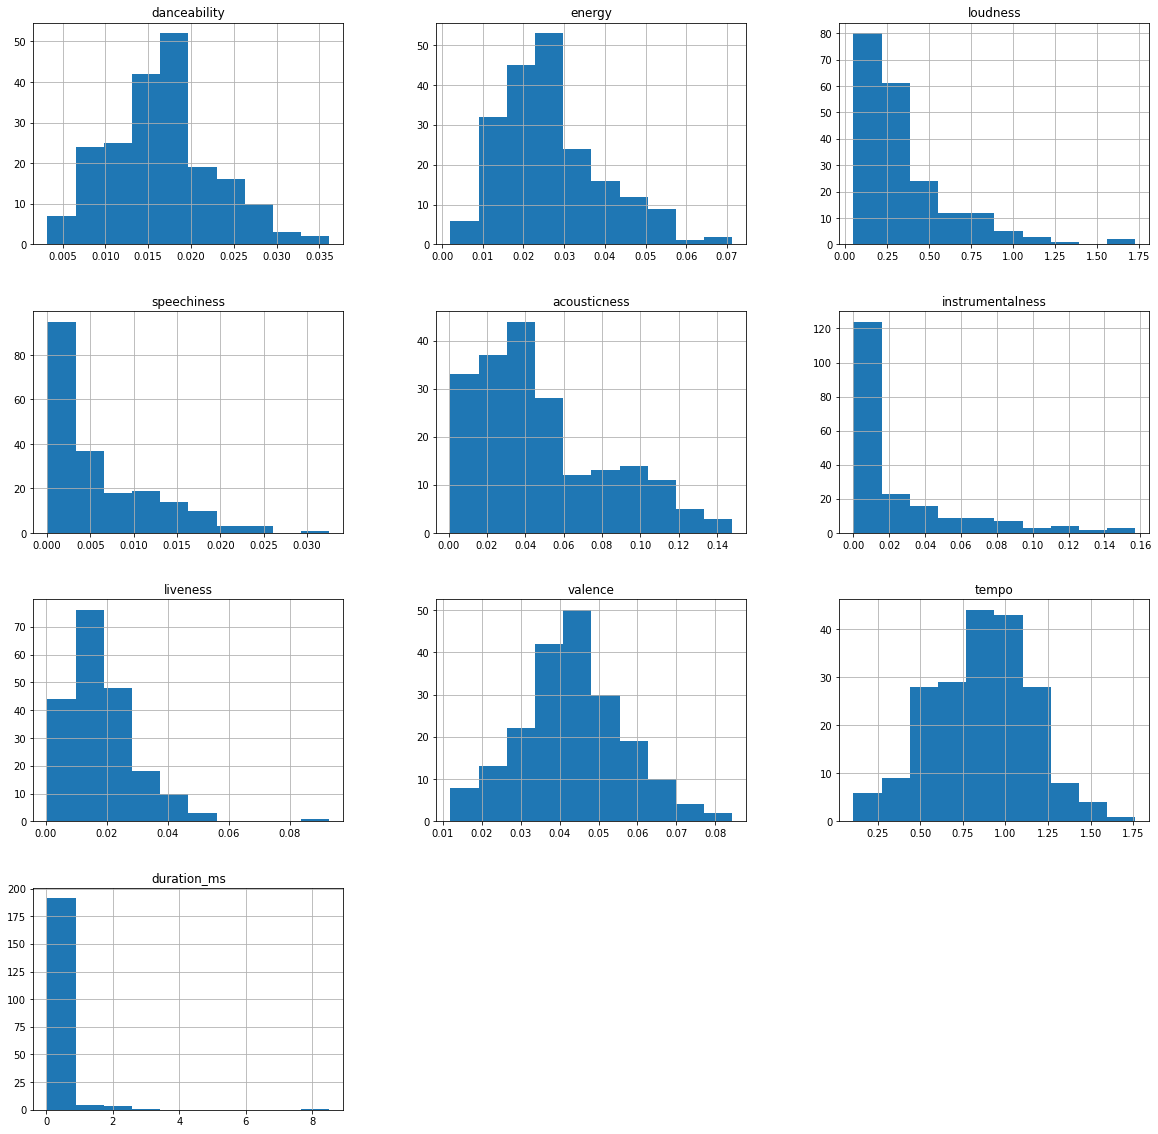

In [28]:
var_hists = pd.DataFrame(feat_vars)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

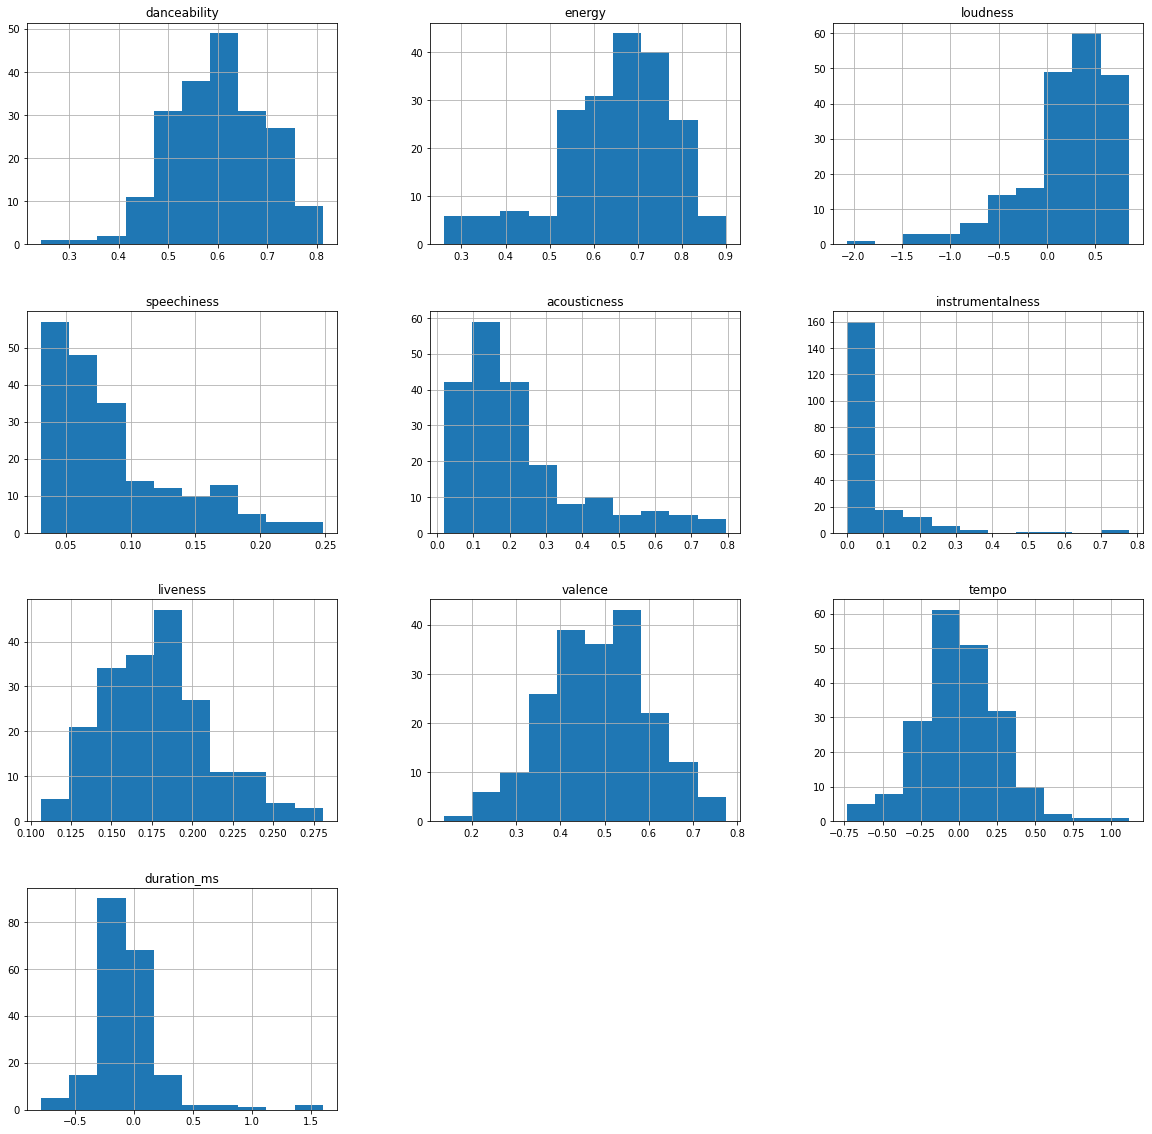

In [29]:
avg_hists = pd.DataFrame(feat_avgs)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

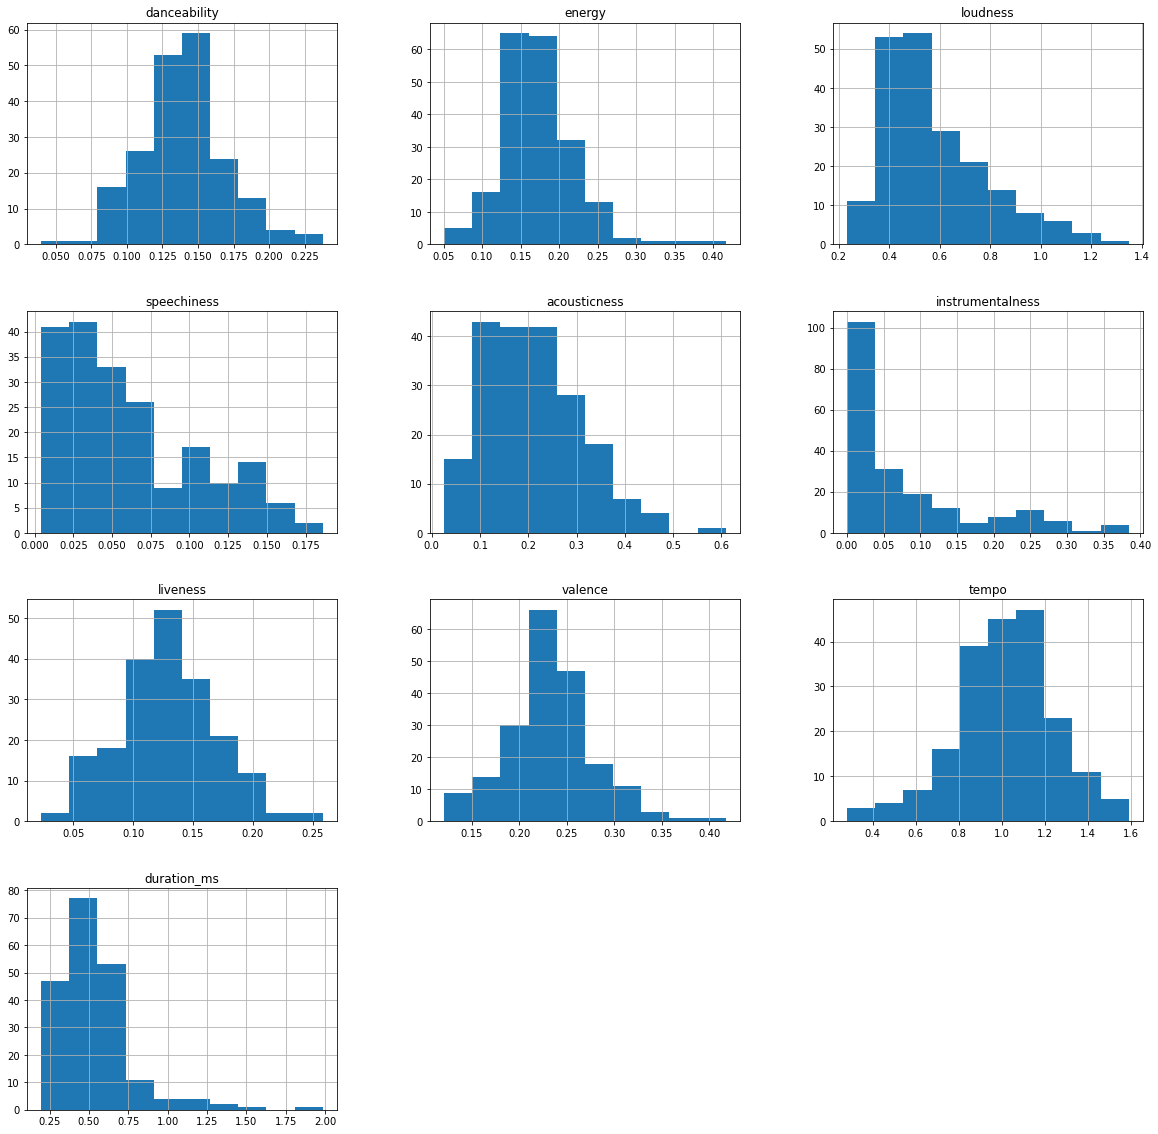

In [30]:
difs_hists = pd.DataFrame(feat_difs)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

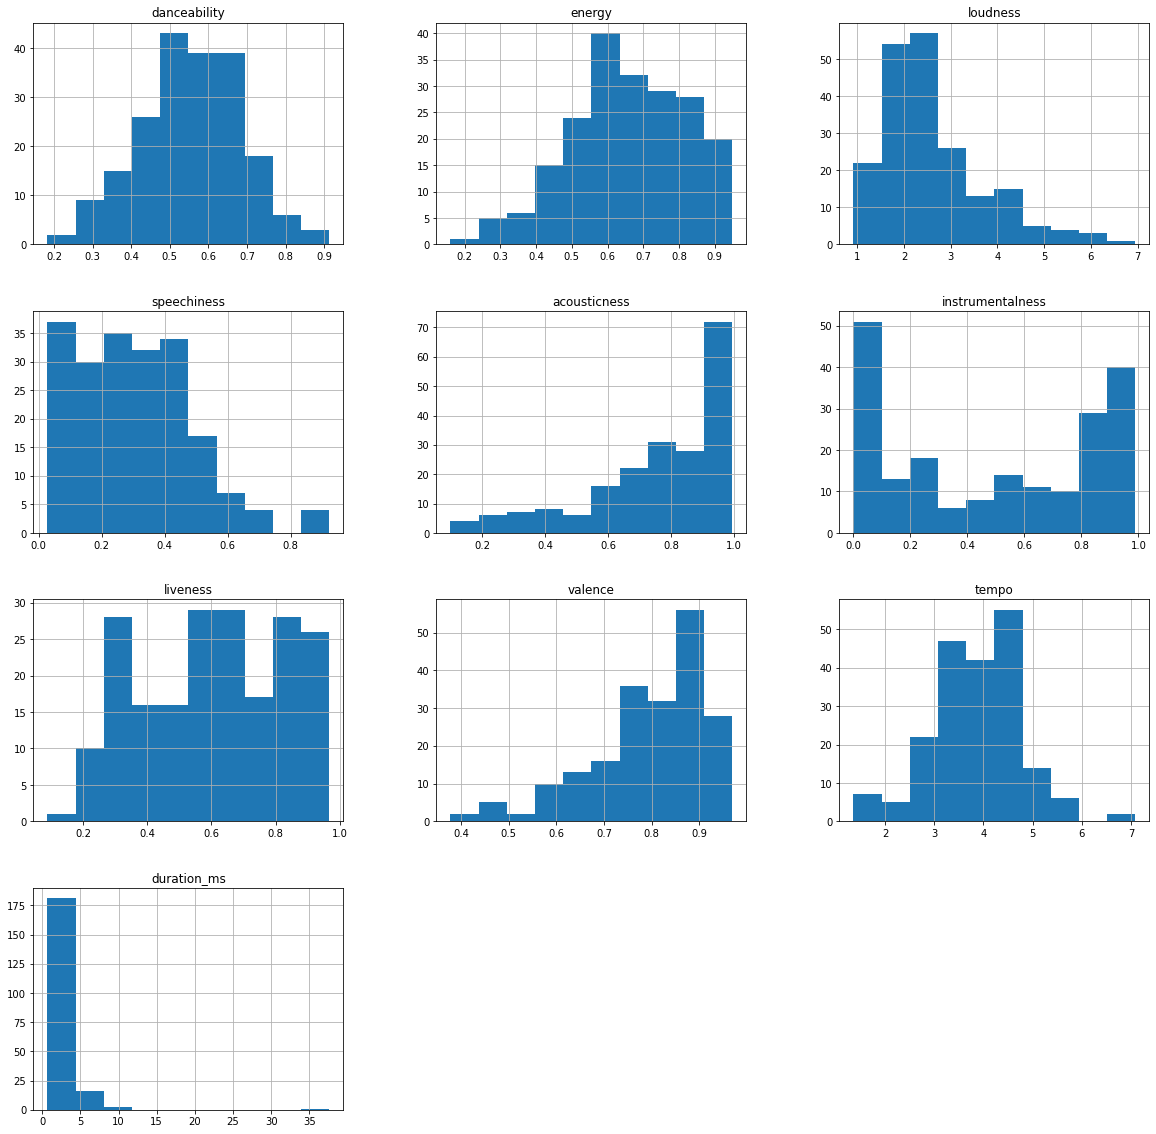

In [31]:
ranges_hists = pd.DataFrame(feat_ranges)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

# Overall Songs EDA

<AxesSubplot:ylabel='time_signature'>

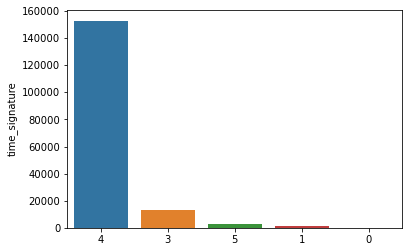

In [32]:
sns.barplot(y=edafeats['time_signature'].value_counts(), x=[str(i) for i in edafeats['time_signature'].value_counts().index])

<AxesSubplot:ylabel='key'>

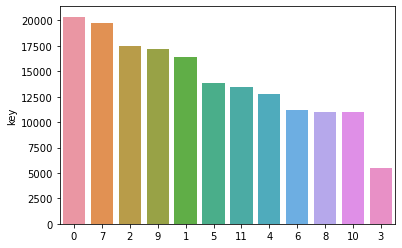

In [33]:
sns.barplot(y=edafeats['key'].value_counts(), x=[str(i) for i in edafeats['key'].value_counts().index])

<AxesSubplot:ylabel='mode'>

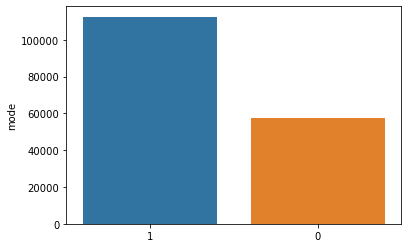

In [34]:
sns.barplot(y=edafeats['mode'].value_counts(), x=[str(i) for i in edafeats['mode'].value_counts().index])

<AxesSubplot:xlabel='energy', ylabel='Count'>

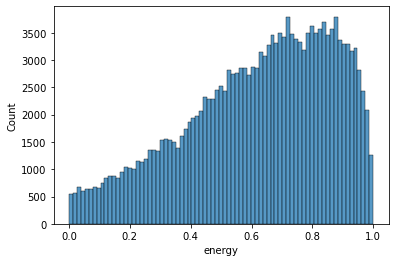

In [35]:
sns.histplot(edafeats['energy'])

<AxesSubplot:xlabel='danceability', ylabel='Count'>

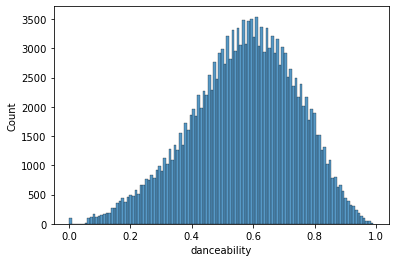

In [36]:
sns.histplot(edafeats['danceability'])

<AxesSubplot:xlabel='loudness', ylabel='Count'>

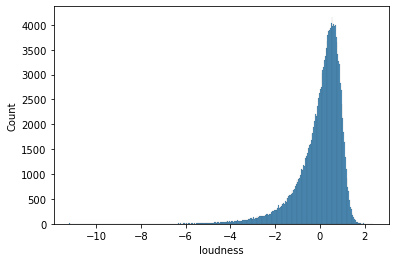

In [37]:
sns.histplot(edafeats['loudness'])

<AxesSubplot:xlabel='speechiness', ylabel='Count'>

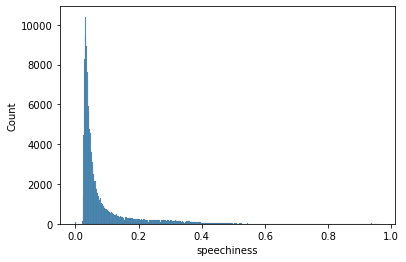

In [38]:
sns.histplot(edafeats['speechiness'])

<AxesSubplot:xlabel='acousticness', ylabel='Count'>

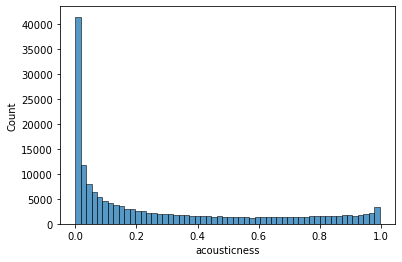

In [39]:
sns.histplot(edafeats['acousticness'])

<AxesSubplot:xlabel='instrumentalness', ylabel='Count'>

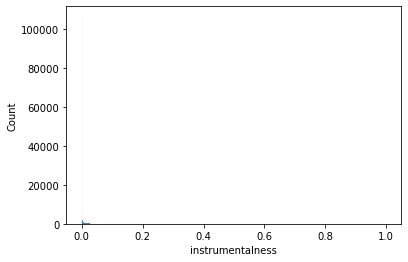

In [41]:
sns.histplot(edafeats['instrumentalness'])

In [ ]:
sns.histplot(edafeats['liveness'])

In [ ]:
sns.histplot(edafeats['valence'])

In [ ]:
sns.histplot(edafeats['tempo'])

In [ ]:
sns.histplot(edafeats['duration_ms'])